In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from hessian import *
import operator


In [2]:
train_data=torchvision.datasets.MNIST('./', train=True, download=True,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.MNIST('./', train=False, download=True,transform=torchvision.transforms.ToTensor())
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

In [3]:
train_dict={}
for (data, target) in train_data:
    if  target not in train_dict:
        train_dict[ target]=[]
        train_dict[ target].append(data)
    else:
        train_dict[ target].append(data)

In [22]:
initial_train_data=[]
initial_train_label=[]
for i in range(2):
    for j in range(0,10):
        initial_train_data.append(train_dict[i][j])
        initial_train_label.append(i)
    
print(initial_train_label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [23]:
initial_train_data_tensor=torch.stack(initial_train_data)
initial_train_label_tensor=torch.tensor(initial_train_label)
train_x=torch.stack([data for (data, target) in train_data])
train_label=torch.tensor([target for (data, target) in train_data])
print(initial_train_data_tensor.size())
print(initial_train_label_tensor.size())

torch.Size([20, 1, 28, 28])
torch.Size([20])


In [125]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 20)
        self.q_mu=torch.nn.Parameter(nn.init.zeros_(torch.empty(200)))
        self.q_diag=torch.nn.Parameter(nn.init.ones_(torch.empty(200))*0.1)
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x, final_weight):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =self.fc2(x)
#         final_weight_sample=self.q_dis.rsample().view(20,10)
        x= torch.matmul(x,final_weight)
        return F.log_softmax(x,dim=-1)
    
    
    def feature_forward(self, x ):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =  self.fc2(x)
        return x
    
    def predict(self,x):
        with torch.no_grad():
            eps=torch.tensor(np.random.normal([200]),dtype=torch.float)
            final_weight_sample= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(20,10)
            output = torch.exp(self.forward(x,final_weight_sample))
            pred = output.data.max(dim=1, keepdim=True)[1]
            return pred
        
    def test_prediction(self, x):
        with torch.no_grad():
            final_weight_mean=self.q_mu.view(20,10)
            output = torch.exp(self.forward(x,final_weight_mean))
            pred = output.data.max(dim=1, keepdim=True)[1]
            return pred
        
        
    def predictive_distribution_entropy(self,x):
        
#         final_weight_samples=self.posterior.sample([100]).view(100,20,10).permute(0, 2, 1)
        eps=torch.tensor(np.random.normal(size=[100,200]),dtype=torch.float)
#         print(eps.size())
        final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,200)*eps+self.q_mu).view(100,20,10).permute(0, 2, 1)
#         final_weight_sample=_batch_mv(torch.sqrt(self.q_diag).view(1,-1),eps)#+self.q_mu
#         print(final_weight_samples.size())

#         final_weight_samples=self.posterior.mean.repeat([100,1]).view(100,20,10).permute(0, 2, 1)
#         print(final_weight_samples.size())
        feature_of_data=self.feature_forward(x)[0]
#         print(feature_of_data.size())
        output_logit=final_weight_samples@feature_of_data
#         print(output_logit.size())
        # output_probs=torch.exp(output_logit)
#         print(output_logit)
        output_dis=torch.distributions.categorical.Categorical(logits=output_logit)
        
        sample=output_dis.sample([100]).reshape([-1,1])
#         print(sample)
        entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
#         print(entropy)
        
        return entropy
    
    def pre_train(self,x,label):
        train_losses = []
        entropy_list = []
        for it in range(0,10000):
            self.optimizer.zero_grad()
#             conditional_loss=0
#             for i in range(0,10):
            eps=torch.tensor(np.random.normal(size=[200]),dtype=torch.float)
            final_weight_sample= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(20,10)
            output = self.forward(x,final_weight_sample)

            conditional_loss= F.nll_loss(output,label,reduction='sum')
#             conditional_loss=conditional_loss/10
            entropy=torch.sum(torch.log(self.q_diag))
            neg_kl=entropy-0.5 * torch.sum((self.q_diag + self.q_mu**2))
            neg_elbo=-neg_kl+conditional_loss
            neg_elbo.backward()
            self.optimizer.step()
            train_losses.append(neg_elbo.item())
            entropy_list.append(entropy.item())
        print('labels')
        print(label)
        print(output.data.max(dim=1, keepdim=True)[1])
#         print(self.q_mu)
        plt.plot(train_losses)
        plt.show()
        plt.plot(entropy_list)
        plt.show()
        
        
    def test(self):
        correct=0
        for data, target in test_loader:
            pred = self.predict(data)
            correct += pred.eq(target.data.view_as(pred)).sum()
            correct_ratio= float(correct)/len(test_loader.dataset)
        return correct_ratio
    

labels
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])


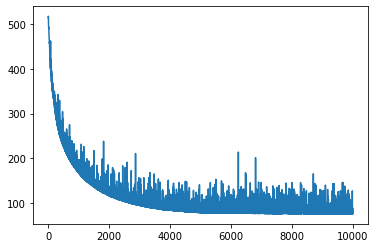

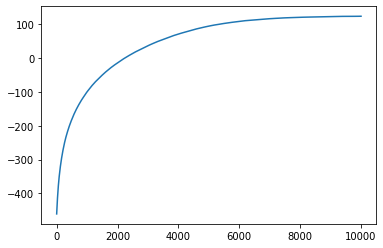

In [126]:
active_bnn = Net()
active_bnn.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [132]:
print(active_bnn.test_prediction(initial_train_data_tensor))
# print(active_bnn.predict(initial_train_data_tensor))

print(active_bnn.predictive_distribution_entropy(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[0][1]))

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
tensor(1.0977, grad_fn=<NegBackward>)
tensor(0.9222, grad_fn=<NegBackward>)
tensor(0.7538, grad_fn=<NegBackward>)
tensor(0.5118, grad_fn=<NegBackward>)
tensor(0.6449, grad_fn=<NegBackward>)
